In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

In [2]:
# loading the data and doing a sanity check to make sure all necessary columns are present
branded_df = pd.read_csv("../DATA/processed/branded_food_clean.csv")
branded_df = branded_df.sample(n=10000, random_state=42)

expected_cols = {'fdc_id', 'product_name', 'ingredients_list_json', 'num_ingredients'}

missing_cols = expected_cols - set(branded_df.columns)

if missing_cols:
  print(f"Missing columns: {missing_cols}")
else:
  print("All expected columns are present")

All expected columns are present


In [3]:
def parse_json(json_record):
  if pd.isna(json_record):
    return []

  record =  str(json_record).strip()

  if record.startswith('[') and record.endswith(']'):
    try:
            items = json.loads(record)
    except Exception:
            items = record.split(',')

  else:
    items = record.split(',')

  norm = []
  for it in items:
        tok = re.sub(r"^ingredients\s*:\s*", "", str(it), flags=re.IGNORECASE).strip().lower()
        # remove 'made from...' or 'made with...' and everything after it
        tok = re.sub(r"\bmade\s+(from|with)\b.*", "", tok).strip()
        # keep only letters, digits, %, spaces, and hyphens
        tok = re.sub(r"[^a-z0-9%\s\-]", " ", tok)
        tok = re.sub(r"\s+", " ", tok).strip()
        if tok:
            norm.append(tok)
  return norm

branded_df['ingredients_list'] = branded_df['ingredients_list_json'].apply(parse_json)


In [10]:
def rank_weight(rank, alpha = 0.6, scale = 1.0):
  return scale / (rank ** alpha)

def order_weight_tokens(ing_list, alpha=0.6, scale=6):
    """
    Create a string where earlier ingredients are repeated more often.
    alpha controls how quickly weight decays with rank.
    scale controls how many repetitions the first ingredient gets.
    """
    bag = []
    for rank, item in enumerate(ing_list, start=1):
        weight = 1 / (rank ** alpha)  # position decay
        reps = max(1, int(weight * scale))  # repeat token
        bag.extend([item] * reps)
    return " , ".join(bag)

branded_df['ordered_text'] = branded_df['ingredients_list'].apply(order_weight_tokens)


def lf_any(tokens, pattern, base_weight=1.0, alpha=0.6):
    pat = re.compile(pattern)
    score = 0.0
    for i, t in enumerate(tokens, start=1):
        if pat.search(t):
            score += base_weight * rank_weight(i, alpha=alpha)
    return score

LFs_negative = {
    # Colors / dyes (incl. Red No. 3)
    "artificial_colors": (r"\b(red\s*0*3|red\s*no\.?\s*3|red\s*3|yellow\s*5|yellow\s*6|blue\s*1|artificial color|artificial colours?)\b", 1.5),
    # Titanium dioxide
    "titanium_dioxide": (r"\btitanium\s+dioxide\b", 1.5),
    # Potassium bromate
    "potassium_bromate": (r"\bpotassium\s+bromate\b", 1.6),
    # Brominated vegetable oil
    "bvo": (r"\bbrominated\s+vegetable\s+oil\b", 1.6),
    # Parabens (incl. propylparaben)
    "parabens": (r"\b(parabens?|propylparaben|methylparaben|butylparaben)\b", 1.2),
    # High fructose / corn syrup / added sugars cluster
    "hfcs_syrups_sugars": (r"\b(high\s*fructose\s*corn\s*syrup|hfcs|corn\s*syrup|glucose[-\s]*fructose|invert\s*sugar|sucrose|dextrose|fructose|glucose|molasses)\b", 1.8),
    # Nitrites/nitrates
    "nitrites": (r"\b(sodium|potassium)\s+(nitrite|nitrate)s?\b", 1.6),
    # TBHQ / BHA / BHT antioxidants
    "synthetic_antioxidants": (r"\b(tbhq|tertiary\s*butylhydroquinone|bha|butylated\s*hydroxyanisole|bht|butylated\s*hydroxytoluene)\b", 1.3),
    # Artificial sweeteners
    "non_nutritive_sweeteners": (r"\b(aspartame|acesulfame\s*k?|acesulfamek|sucralose|saccharin|neotame|advantame)\b", 1.2),
    # Hydrogenated/shortening (often avoided; reasonable to include)
    "hydrogenated_fats": (r"\b(partially\s+)?hydrogenated\b|\bshortening\b", 1.6),
     # Salt / sodium chloride (very common; keep weight modest + rely on position)
    "salt": (r"\b(salt|sodium\s+chloride)\b", 1.0),
    # Refined grains (enriched/bleached flour)
    "refined_flour": (r"\b(enriched|bleached)\s+(wheat\s+)?flour\b", 1.0),
    # Palm / tropical saturated oils
    "palm_coconut_oil": (r"\b(palm(\s+kernel)?\s+oil|coconut\s+oil)\b", 1.0),
    # Maltodextrin
    "maltodextrin": (r"\bmaltodextrin\b", 0.8),
    # MSG
    "msg": (r"\b(monosodium\s+glutamate|msg)\b", 1.0),
    # Preservatives (benzoate / sorbate / propionate)
    "preservatives": (r"\b(sodium|potassium|calcium)\s+(benzoate|sorbate|propionate)s?\b", 1.3),
    # Phosphates (texture enhancers)
    "phosphates": (r"\b(sodium|potassium|calcium)\s+\w*phosphate(s)?\b", 0.9),
    # Caramel color / color added
    "caramel_color": (r"\b(caramel\s+color|color\s+added)\b", 0.8),
    # Emulsifiers / thickeners
    "emulsifiers": (r"\b(mono-?\s* and-?\s*diglycerides|polysorbate\s*80|propylene\s+glycol|datem|pgpr|modified\s+starch)\b", 0.9),
    # Gums (treat carrageenan stronger)
    "gums": (r"\b(xanthan\s+gum|guar\s+gum|gellan\s+gum|locust\s+bean\s+gum)\b", 0.6),
    "carrageenan": (r"\bcarrageenan\b", 1.5),
    # Sugar alcohols
    "sugar_alcohols": (r"\b(erythritol|xylitol|sorbitol|mannitol|maltitol|isomalt)\b", 0.9),
    # Artificial / 'natural' flavors (mild but frequent)
    "flavors": (r"\b(artificial\s+flavors?|natural\s+flavors?)\b", 0.6),
}

def score_negative(tokens, alpha = 0.6):
  s = 0.0
  for _, (pat, w) in LFs_negative.items():
      s += lf_any(tokens, pat, base_weight=w, alpha=alpha)
  return s


LFs_positive = {
    "whole_grain_first": (r"\b(whole\s+grain|whole[-\s]*wheat|whole\s*oats?|whole\s*rye|whole\s*barley)\b", 0.8),
     "fresh_produce": (r"\b("
                      r"apple|apples|banana|bananas|berry|berries|blueberry|strawberry|raspberry|blackberry|"
                      r"cherry|cherries|grape|grapes|melon|cantaloupe|honeydew|watermelon|mango|mangos|pineapple|pear|pears|"
                      r"peach|peaches|plum|plums|kiwi|oranges?|clementine|tangerine|lemon|lime|"
                      r"spinach|kale|lettuce|romaine|arugula|chard|collard|broccoli|cauliflower|cabbage|"
                      r"carrot|carrots|celery|beet|beets|radish|radishes|turnip|turnips|"
                      r"onion|onions|garlic|ginger|leek|shallot|scallion|"
                      r"pepper|peppers|bell\s*pepper|tomato|tomatoes|cucumber|zucchini|squash|"
                      r"pumpkin|eggplant|brussels\s*sprouts|asparagus|spinach"
                      r")\b", 1.0),
    "protein": (r"\b("
                r"protein|chicken|beef|pork|turkey|lamb|duck|salmon|tuna|cod|trout|shrimp|prawn|"
                r"crab|lobster|fish|anchovy|sardine|mackerel|egg|eggs|egg\s*white|egg\s*yolk|"
                r"tofu|tempeh|seitan|soy\s*protein|pea\s*protein|whey\s*protein|casein"
                r")\b", 0.7),
    "legumes": (r"\b("
                r"lentil|lentils|chickpea|chickpeas|pea|peas|split\s*peas|black\s*eyed\s*peas|"
                r"legume|legumes"
                r")\b", 0.8),
    "beans": (r"\b("
              r"black\s*bean|black\s*beans|kidney\s*bean|kidney\s*beans|pinto\s*bean|pinto\s*beans|"
              r"navy\s*beans|white\s*beans|cannellini|garbanzo|refried\s*beans|soybeans?|edamame"
              r")\b", 0.8),
    "nuts": (r"\b("
             r"almond|almonds|walnut|walnuts|cashew|cashews|pecan|pecans|pistachio|pistachios|"
             r"hazelnut|hazelnuts|macadamia|macadamias|brazil\s*nuts?|chestnut|chestnuts"
             r")\b", 0.8),
    # Healthy oils
    "healthy_oils": (r"\b((extra\s*virgin\s*)?olive\s+oil|avocado\s+oil|canola\s+oil)\b", 0.5),
    # Seeds
    "seeds": (r"\b(chia|flax|sesame|sunflower|pumpkin)\s+seeds?\b", 0.8),
    # Whole grains (expand coverage)
    "whole_grains_extra": (r"\b(brown\s+rice|quinoa|buckwheat|oat\s*bran|wheat\s*bran)\b", 0.9),
    # Fiber-rich isolates (small positive)
    "fiber": (r"\b(psyllium|inulin|oat\s*fiber|apple\s*fiber)\b", 0.7),
    # Fermented / live cultures (modest)
    "fermented": (r"\b(live\s+active\s+cultures|yogurt\s+cultures|kefir|sauerkraut|kimchi)\b", 0.6),
    # Herbs/spices (tiny bump; they often ride along with processed foods)
    "herbs_spices": (r"\b(turmeric|cumin|oregano|basil|thyme|rosemary|cilantro|parsley)\b", 0.3),
}

def score_positive(tokens, alpha = 0.6):
  s = 0.0
  for _, (pat, w) in LFs_positive.items():
    s += lf_any(tokens, pat, base_weight=w, alpha=alpha)
  return s

def length_penalty(tokens, cutoff = 12, per_extra = 0.03):
  extra = max(0, len(tokens) - cutoff)
  return extra * per_extra


In [11]:
def weak_score(tokens, alpha=0.6):
  base = score_negative(tokens, alpha=alpha) - 0.9 * score_positive(tokens, alpha=alpha)
  return base + length_penalty(tokens)


def score_to_label(score, t_healthy = -0.5, t_unhealthy = -0.1):
  if score < t_healthy:
    return 'healthy'
  elif score > t_unhealthy:
    return 'unhealthy'
  else:
    return 'intermediate'

def apply_snorkel_labels(df, ing_col="ingredients_list", alpha=0.6,
                         t_healthy=None, t_unhealthy=None, use_quantiles=True):
    df = df.copy()
    df["weak_score"] = df[ing_col].apply(lambda lst: weak_score(lst, alpha=alpha))
    if use_quantiles:
        q_low, q_high = df["weak_score"].quantile([0.33, 0.67])
        t_healthy = q_low if t_healthy is None else t_healthy
        t_unhealthy = q_high if t_unhealthy is None else t_unhealthy
    elif t_healthy is None or t_unhealthy is None:
        # sensible fallbacks
        t_healthy, t_unhealthy = -0.4, 0.6
    df["label"] = df["weak_score"].apply(lambda s: score_to_label(s, t_healthy, t_unhealthy))
    return df, {"t_healthy": t_healthy, "t_unhealthy": t_unhealthy}


labeled_df, thresholds = apply_snorkel_labels(branded_df, ing_col="ingredients_list", alpha=0.6)
print(thresholds)
binary_df = labeled_df[labeled_df['label'] != 2].copy()

{'t_healthy': -0.20081285012649774, 't_unhealthy': 0.7225269573576208}


In [13]:
# Threshold Tuning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

import warnings
from sklearn.exceptions import ConvergenceWarning

def relabel(df, th, tu, alpha=0.6):
    new_df, _ = apply_snorkel_labels(df, ing_col="ingredients_list",
                                     alpha=alpha, t_healthy=th, t_unhealthy=tu,
                                     use_quantiles=False)
    return new_df

def quick_f1(df):
    X = df["ordered_text"].fillna("").astype(str)
    y = df["label"].astype(str)
    m = X.str.strip().str.len() > 0
    X, y = X[m], y[m]
    X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5, token_pattern=r"(?u)\b\w+\b")),
        ("lr", LogisticRegression(max_iter=2000, solver="saga", class_weight="balanced", n_jobs=-1)),
    ])

    # Ignore noisy warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        pipe.fit(X_tr, y_tr)
        y_hat = pipe.predict(X_va)
        
    return f1_score(y_va, pipe.predict(X_va), average="macro", zero_division=0)

# small search (fast). tweak ranges if needed.
best = (-1, None, None)
for th in np.linspace(-1.2, -0.1, 8):   # t_healthy candidates
    for tu in np.linspace(0.0, 0.8, 8): # t_unhealthy candidates
        f1 = quick_f1(relabel(branded_df, th, tu, alpha=0.6))
        if f1 > best[0]:
            best = (f1, th, tu)

print(f"[tuning] best macro-F1={best[0]:.3f} at t_healthy={best[1]:.3f}, t_unhealthy={best[2]:.3f}")

# use the tuned thresholds for the rest of the notebook
labeled_df, _ = apply_snorkel_labels(branded_df, ing_col="ingredients_list",
                                     alpha=0.6, t_healthy=best[1], t_unhealthy=best[2],
                                     use_quantiles=False)


[tuning] best macro-F1=0.864 at t_healthy=-0.414, t_unhealthy=0.800


In [14]:
multi_df = labeled_df.copy()

# features and labels
X = multi_df["ordered_text"].fillna("")
y = multi_df["label"]   # {'healthy','intermediate','unhealthy'}

mask = X.str.strip().str.len() > 0
X, y = X[mask], y[mask]

print("Class counts:", y.value_counts().to_dict())

# Split of three classes
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
rel_val = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
)

Class counts: {'intermediate': 4049, 'unhealthy': 3168, 'healthy': 2780}


Saved figure to: C:\Users\nifft\Downloads\DS[4002] Project1\SCRIPTS\OUTPUT\class_distribution.png


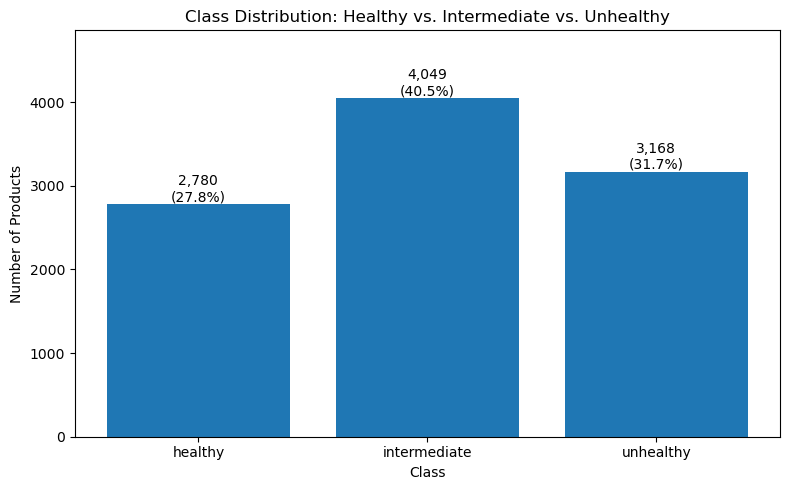

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ----- 1) Prep counts in a fixed order -----
order = ["healthy", "intermediate", "unhealthy"]
counts = y.value_counts()
labels = [c for c in order if c in counts.index]
vals = counts.reindex(labels, fill_value=0).astype(int)

# ----- 2) Plot bar with count + % labels -----
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, vals.values)
ax.set_title("Class Distribution: Healthy vs. Intermediate vs. Unhealthy")
ax.set_ylabel("Number of Products")
ax.set_xlabel("Class")

total = vals.sum()
for i, v in enumerate(vals.values):
    pct = (v / total) * 100 if total else 0
    ax.text(i, v, f"{v:,}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=10)
    
# add vertical margin so text fits
ax.set_ylim(0, max(vals.values) * 1.20)

fig.tight_layout()

# ----- 3) Save to OUTPUT/ and show -----
outdir = Path("OUTPUT"); outdir.mkdir(exist_ok=True)
outpath = outdir / "class_distribution.png"
fig.savefig(outpath, dpi=300, bbox_inches="tight")
print("Saved figure to:", outpath.resolve())

plt.show()


In [17]:
labeled_df[labeled_df['label'] == 'healthy'].sample(20)[['product_name', 'ingredients_list_json']]

,product_name,ingredients_list_json
1929291,Tyson All Natural* IF Unbreaded Chicken Thighs,"[""chicken thighs without back portion""]"
669754,MANDARIN ORANGE SEGMENTS IN LIGHT SYRUP,"[""mandarin orange segments"", ""water"", ""sugar"",..."
1566331,"MIXED VEGETABLES LOW SODIUM CARROTS, POTATOES,...","[""water"", ""carrots"", ""potatoes"", ""peas"", ""corn..."
36230,V8 V-FUSION BEVERAGE PEACH MANGO,"[""vegetable juice"", ""fruit juice"", ""mango pure..."
336780,IRISH OATMEAL QUICK COOK HOT CEREAL,"[""whole grain oats""]"
861182,"CASA CARDENAS, 100% PURE VEGETABLE OIL","[""soybean oil""]"
1162868,ORGANIC UNSALTED DRY ROASTED ALMONDS,"[""organic almonds""]"
1290450,YELLOW SLICED DRIED PEACHES,"[""yellow peaches""]"
1629470,PINEAPPLE SLICES IN PINEAPPLE JUICE FROM CONCE...,"[""pineapple"", ""water"", ""pineapple juice concen..."
1199857,"BEEF MEATBALLS, BEEF","[""beef"", ""water"", ""seasoning: corn flour"", ""ri..."


In [18]:
labeled_df[labeled_df['label'] == 'unhealthy'].sample(20)[['product_name', 'ingredients_list_json']]

,product_name,ingredients_list_json
1971374,"Bagels, Whole Grain, Cinnamon Raisin, Sliced, ...","[""whole wheat flour"", ""enriched wheat flour"", ..."
1521211,"CARAMEL APPLE FLAVORED PREMIUM COOKIE MIX, CAR...","[""sugar"", ""enriched bleached flour"", ""canola o..."
1082469,"CHOCOLATE NON DAIRY PROTEIN SHAKE, CHOCOLATE","[""water"", ""milk protein isolate"", ""calcium cas..."
831168,"BLACK RASPBERRY JELLY, BLACK RASPBERRY","[""black raspberries"", ""high fructose corn syru..."
1782653,"OLIVE OIL ARTISAN CIABATTA, OLIVE OIL","[""enriched flour"", ""water"", ""each of the follo..."
46168,"NATURE'S CRUNCH, RAISIN BRAN CEREAL","[""whole grain wheat"", ""raisins"", ""wheat bran"",..."
1760085,"ENRICHED WHITE SANDWICH BREAD, ENRICHED WHITE","[""enriched flour [unbleached wheat flour"", ""ma..."
856044,Aunt Jemima Complete Buttermilk Pancake & Waff...,"[""enriched bleached flour"", ""sugar"", ""leavenin..."
1139837,"ROUNDY'S, THREE CHEESE SCALLOPED POTATOES","[""dehydrated potato with preservative"", ""corn ..."
1612265,"NACHO CHEESE SAUCE, NACHO CHEESE","[""cheese whey"", ""water"", ""modified food starch..."


In [19]:
labeled_df[labeled_df['label'] == 'intermediate'].sample(20)[['product_name', 'ingredients_list_json']]

,product_name,ingredients_list_json
774742,COOKED DRY BLACKEYE PEAS,"[""prepared blackeye peas"", ""water"", ""salt"", ""c..."
441457,WHITE CHOCOLATE-FLAVORED RASPBERRY ICE CREAM W...,"[""milk"", ""cream"", ""sugar"", ""corn syrup"", ""whit..."
1709393,"HOMESTYLE CHICKEN STOCK, ROTISSERIE CHICKEN","[""filtered water"", ""chicken flavor"", ""salt"", ""..."
1295043,"ELDERBERRY JAM, ELDERBERRY","[""elderberries"", ""pure cane sugar"", ""fruit pec..."
778663,KALAMATA OLIVES & FIG SPREAD,"[""kalamata olives"", ""figs"", ""water"", ""apple ju..."
568681,"ORVILLE REDENBACHERS Skinny Girl Popcorn, 15 OZ","[""whole grain popping corn"", ""palm oil"", ""sea ..."
1691164,"MEDITERRANEAN OLIVE MEDLEY, MEDITERRANEAN OLIVE","[""olives"", ""water"", ""salt"", ""red wine vinegar""..."
1410213,"SHOPRITE, ASIAN SZECHUAN SAUCE","[""water"", ""sugar"", ""soy sauce"", ""corn syrup"", ..."
135810,MICHIGAN APPLES,"[""nan""]"
1461940,MOZZARELLA CHEESE LOW MOISTURE PART SKIM SHRED...,"[""low moisture part skim mozzarella cheese"", ""..."


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3,
                              token_pattern=r"(?u)\b\w+\b")),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [None, 20, 40],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
}

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid, cv=cv,
    scoring="f1_macro",   # or "f1_weighted"
    n_jobs=-1, verbose=1, error_score="raise"
)

grid.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'rf__max_depth': 40, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 600}
Best CV f1_macro: 0.7790755884449243
              precision    recall  f1-score   support

     healthy       0.86      0.71      0.77        51
intermediate       0.72      0.81      0.76        52
   unhealthy       0.90      0.96      0.93        47

    accuracy                           0.82       150
   macro avg       0.83      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



Test Accuracy: 0.82
Test F1 (macro): 0.8218883211899507

Classification Report:
               precision    recall  f1-score   support

     healthy       0.86      0.71      0.77        51
intermediate       0.72      0.81      0.76        52
   unhealthy       0.90      0.96      0.93        47

    accuracy                           0.82       150
   macro avg       0.83      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



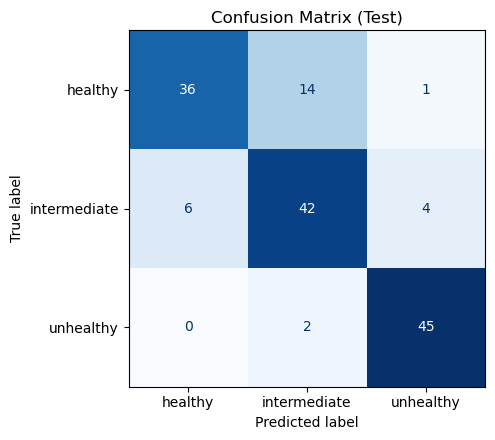

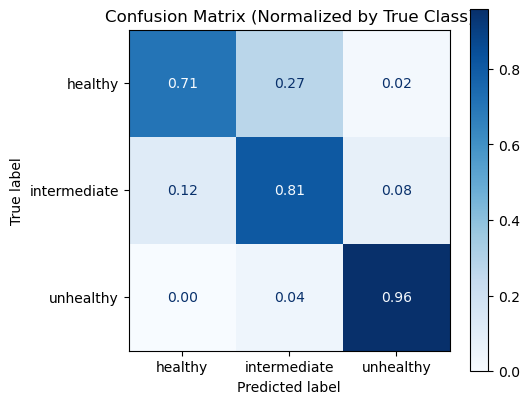

Saved figures to: C:\Users\nifft\Downloads\DS[4002] Project1\OUTPUT


In [13]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score, accuracy_score
)
import matplotlib.pyplot as plt
from pathlib import Path

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# scores
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (macro):", f1_score(y_test, y_pred, average="macro", zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# confusion matrix  (counts)
labels = ["healthy", "intermediate", "unhealthy"]  # ensure consistent order
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(5.5, 4.5))
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("Confusion Matrix (Test)")
plt.tight_layout()

# save file
outdir = Path("../OUTPUT"); outdir.mkdir(parents=True, exist_ok=True)
fig.savefig(outdir / "confusion_matrix_counts.png", dpi=300, bbox_inches="tight")
plt.show()

# Normalized confusion matrix 
cm_norm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")  # rows sum to 1
fig2, ax2 = plt.subplots(figsize=(5.5, 4.5))
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
disp2.plot(ax=ax2, cmap="Blues", values_format=".2f", colorbar=True)
ax2.set_title("Confusion Matrix (Normalized by True Class)")
plt.tight_layout()

# save file
fig2.savefig(outdir / "confusion_matrix_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved figures to:", outdir.resolve())
